In [213]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly
from plotly import graph_objs as go

In [214]:
import plotly.io as pio
pio.templates.default = "presentation"

## The Data

Vacasa would like to add a section to their abandoned cart email which displays 3 similar units to the unit the customer abandoned in their cart. **The objective is to create a programmatic solution to determining 3 similar units for the abandoned cart email, with the ultimate goal of maximizing conversion/revenue from the email.** There are 4 datasets provided, they are described below.

- “official_reservations” is a record of all reservations for Vacasa units made from both
vacasa.com and our channel partners like AirBnB. What you are getting is a subset of
our full table.
- “Units” contains descriptive fields about our units. You are seeing a subset of all of our
units that excludes lat and lng for privacy reasons.
- “Segment page views” contains a list of all page views of unit pages on the website (these
are when a user clicks through to an individual unit). The key here is an anonymous id,
which is an id assigned to a particular browser that visits our web page. Theoretically,
whenever that same browser comes back, it should be assigned the same anonymous
id through browser cookies.
- “segment_reservations” contains a list of the browser sessions that ended in a
reservation. It is joinable to the unit pages viewed table on the anonymous id and
joinable to the official reservations table on the reservation id. You are seeing a masked
subset of our full dataset.

## Exploratory Analysis

### *official_reservations* Dataset

In [215]:
official_reservations = pd.read_csv('data/official_reservations.csv')
official_reservations.head()

,cancelled,unitid,creationdate,firstnight,lastnight,reservation_source_id
0,0,4703,2018-01-01 08:42:41,2018-02-08 00:00:00,2018-02-11 00:00:00,8
1,1,9980,2018-01-01 19:08:32,2018-04-07 00:00:00,2018-04-13 00:00:00,1
2,0,10938,2018-01-02 01:14:25,2018-01-09 00:00:00,2018-01-10 00:00:00,8
3,0,6057,2018-01-02 10:26:26,2018-07-23 00:00:00,2018-07-25 00:00:00,12
4,1,13154,2018-01-02 09:51:18,2018-01-12 00:00:00,2018-01-14 00:00:00,1


In [216]:
official_reservations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92317 entries, 0 to 92316
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cancelled              92317 non-null  int64 
 1   unitid                 92317 non-null  int64 
 2   creationdate           92317 non-null  object
 3   firstnight             92317 non-null  object
 4   lastnight              92317 non-null  object
 5   reservation_source_id  92317 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


There are 6 feature columns in this dataset with no missing values. 

In [217]:
official_reservations.cancelled.value_counts()

0    67923
1    24394
Name: cancelled, dtype: int64

The *cancelled* feature is likely 0 if the reservation was cancelled before the reservation date or 1 if not.

The *unitid* corresponds to the unique key of each unit and can be joined with the *unitid* in the *units* table.

In [218]:
print(f'First reservation date: {official_reservations.creationdate.min()}')

First reservation date: 2018-01-01 00:12:25


In [219]:
print(f'Last reservation date: {official_reservations.creationdate.max()}')

Last reservation date: 2018-12-31 23:58:41


The *official_reservations* dataset includes reservations made in the year 2018. We can assume that the other 3 datasets correspond to the data that existed that year as well, as it's very possible that the data for each unit on the vacasa website has changed since 2018. 

In [220]:
official_reservations.reservation_source_id.nunique()

28

*reservation_source_id* is likely the unique identifier for vacasa or other channel partners through which the reservation was made. There are 28 unique *reservation_source_id*s.

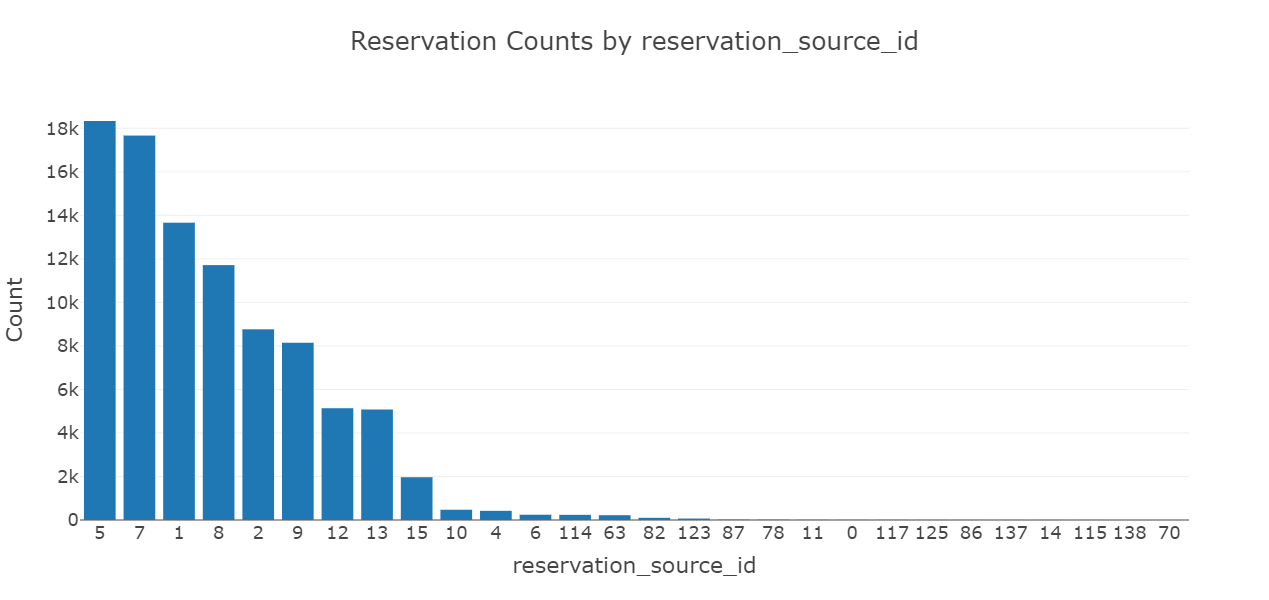

In [221]:
source_id_counts = official_reservations.reservation_source_id.value_counts()
fig = go.Figure(go.Bar(x=source_id_counts.index, y=source_id_counts))
fig.update_layout(title='Reservation Counts by reservation_source_id',
                  yaxis={'title':'Count'},
                  xaxis={'title':'reservation_source_id', 'type':'category'},
                  width=1200,
                  height=600)

fig.show()

Above is a pareto of the number of reservations made for each *reservation_source_id* in 2018.  Indeed, the top 6 sources make up 85% of all reservations in the dataset.

### *Units* Dataset

In [222]:
units = pd.read_csv('data/units.csv')

# set unitid as the index
units.set_index('unitid', inplace=True)
units.head()

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,NaN,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,NaN,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,NaN,NaN,3,1,4.0,0,1.0
1332,130,0,1.0,NaN,4,1,4.0,NaN,1.0
1374,43,0,NaN,NaN,2,1,3.0,NaN,NaN


In [223]:
units.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 251 to 25557
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cityid              2181 non-null   int64  
 1   avgbaserate         2181 non-null   int64  
 2   dogs                548 non-null    float64
 3   maxoccupancyadults  412 non-null    float64
 4   fullbaths           2181 non-null   int64  
 5   terminated          2181 non-null   int64  
 6   bedrooms            2176 non-null   float64
 7   beachaccess         465 non-null    object 
 8   hottub              2120 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 170.4+ KB


The *Units* dataset contains 9 feature columns (above). There are a total of 2,181 individual units. Only 4 of the 9 features contain no null values. Since no information about the features is provided, we will make some assumptions about how the data is collected and how the values should be interpreted. I'll do this as I explore the dataset. I did discover that I can look up the actual listings on the vacasa website using the *unitid*, however many of the units no longer exist on the website. I'll be using ones that do as an example for interpreting the features.

The first unit I'm going to be exploring the data features with is unit 24292. The unit data is shown below, along with the vacasa listing URL and a couple of screenshots of the unit listing.

In [224]:
units.loc[24292]

cityid                545
avgbaserate             0
dogs                  NaN
maxoccupancyadults    0.0
fullbaths               2
terminated              0
bedrooms              2.0
beachaccess           NaN
hottub                1.0
Name: 24292, dtype: object

https://www.vacasa.com/unit/24292

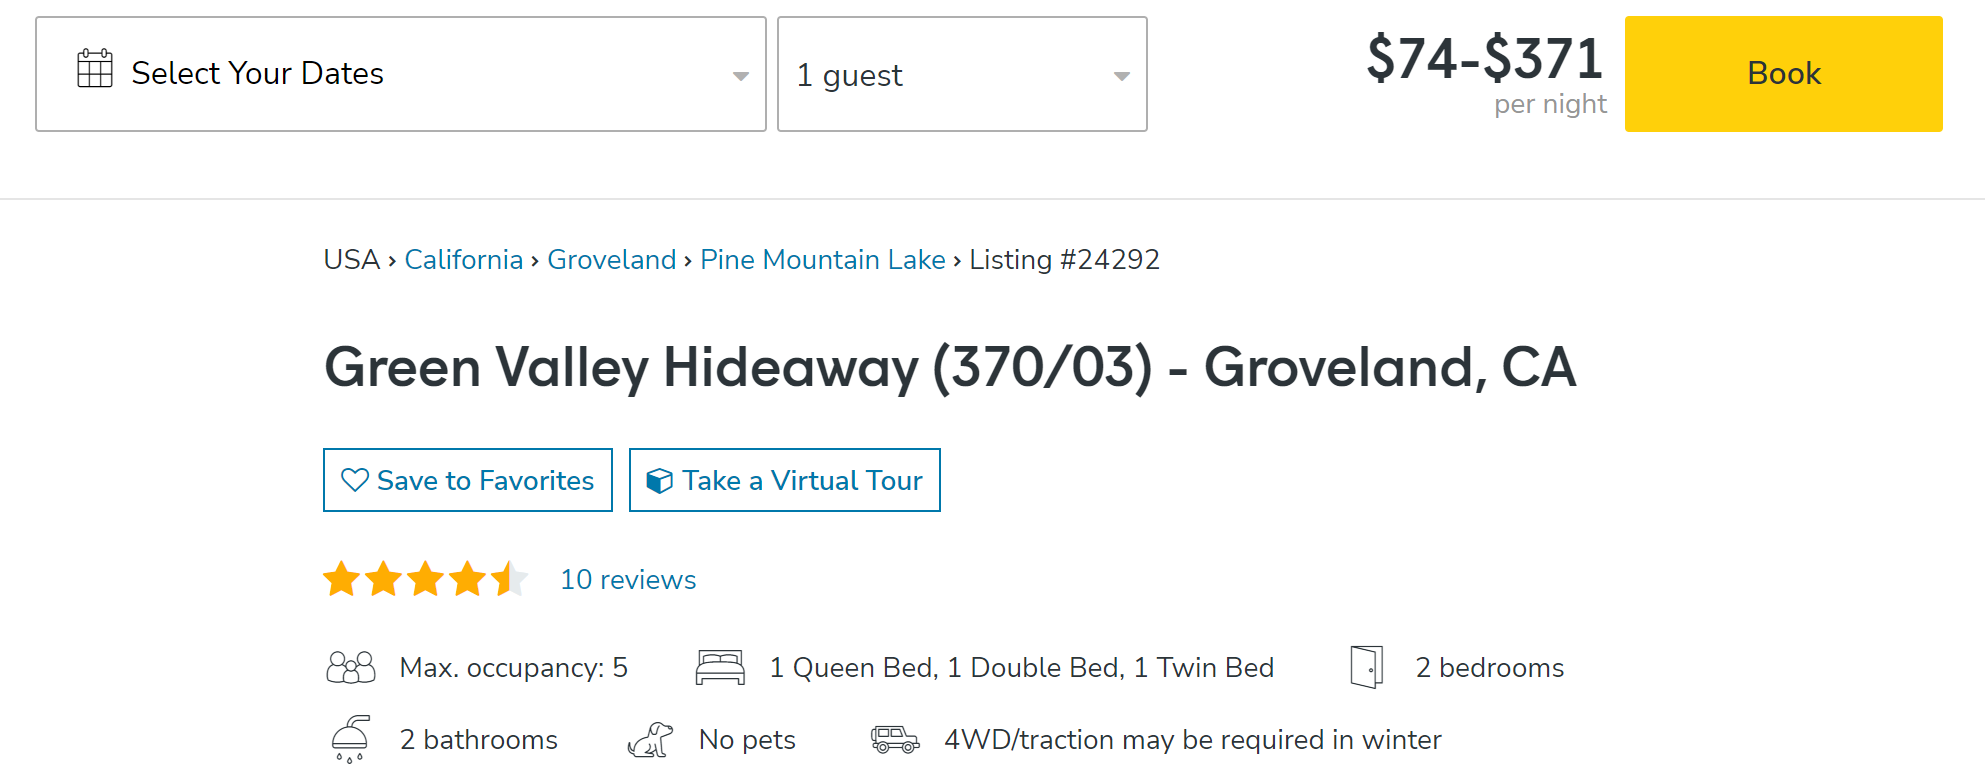

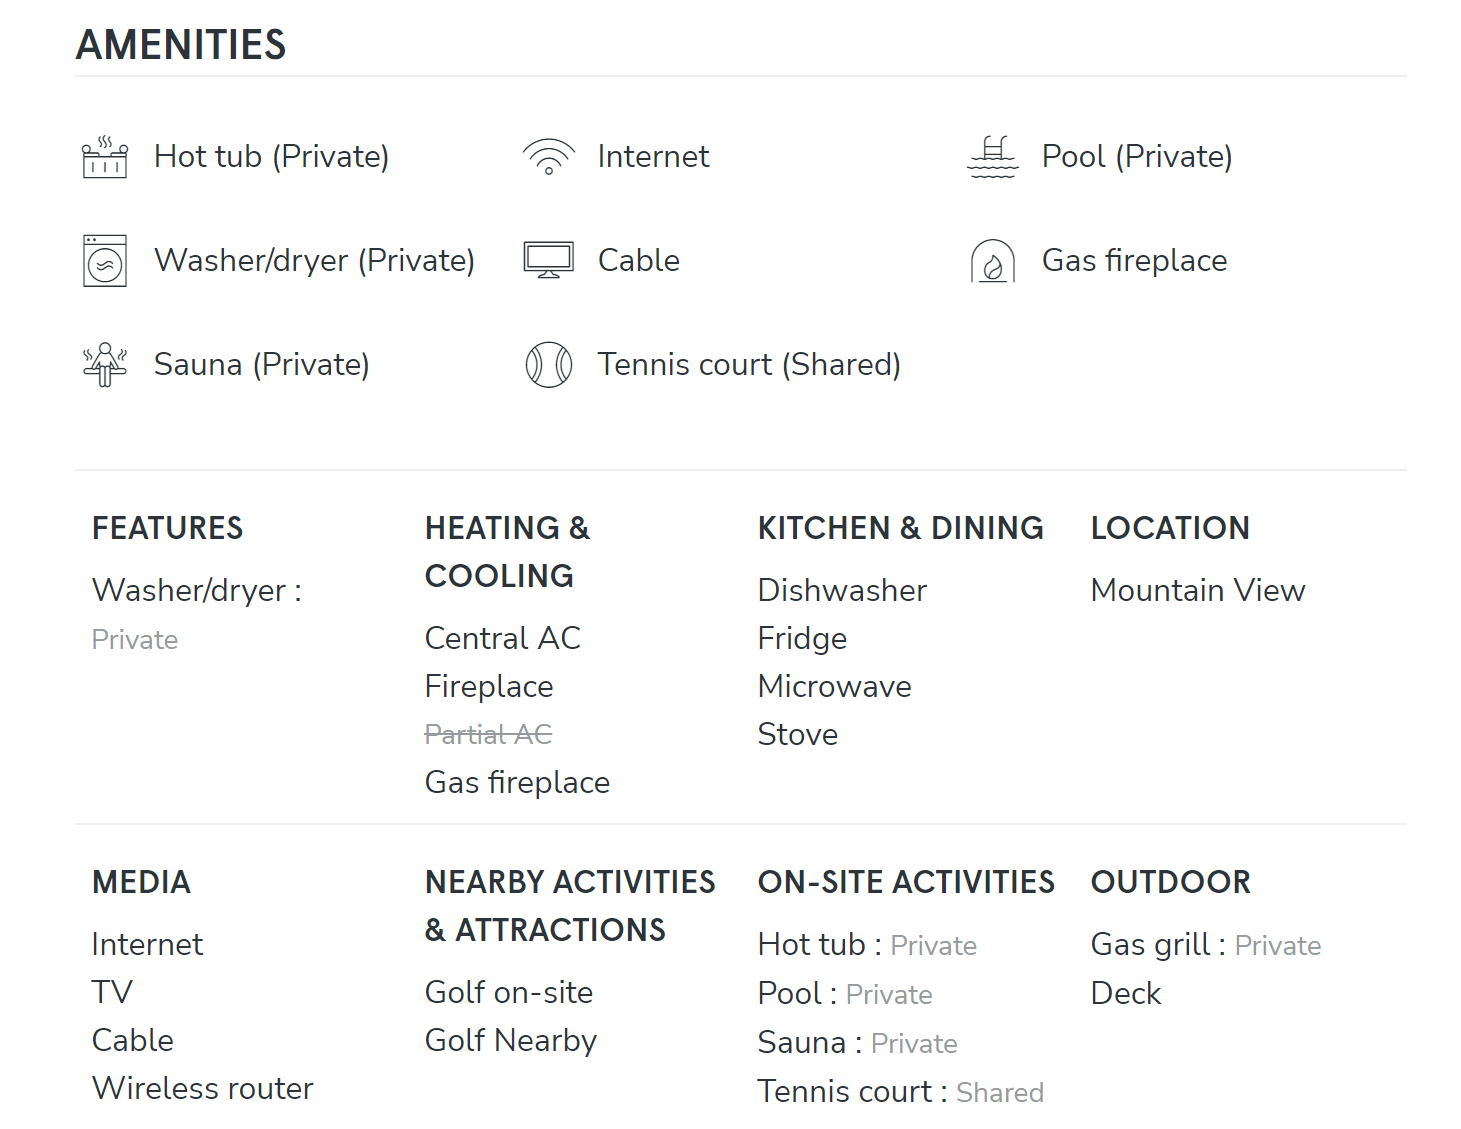

We do have to be careful in this comparison since the vacasa listing is current while the data we are exploring is a snapshot from 2018. As mentioned before, the data for each unit now may look very different. Let's explore each feature in the units table while using this specific listing for reference.

#### *cityid*

In [225]:
units.cityid.nunique()

119

*cityid* seems pretty straightforward and is likely a unique identifier for the city that the unit is in. There are 119 unique cities with no missing values.

#### *avgbaserate*

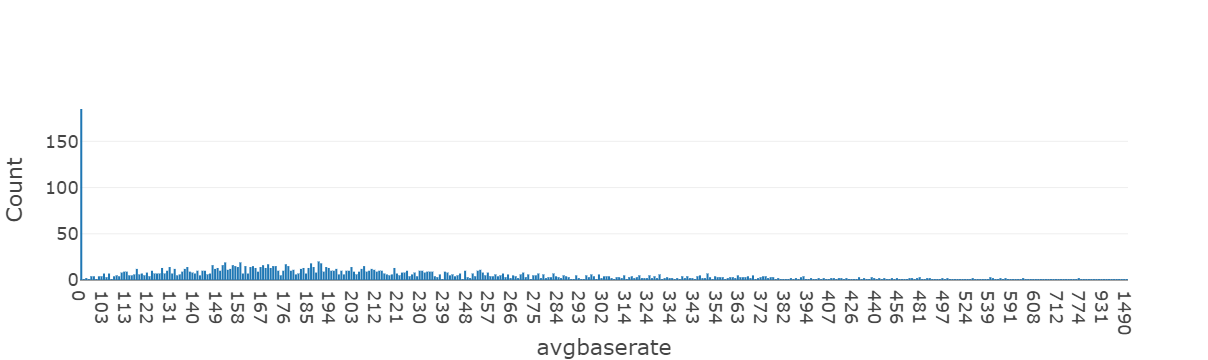

In [399]:
d0 = units.avgbaserate.value_counts(dropna=False).sort_index()
fig = go.Figure(go.Bar(x=d0.index.astype(str), y=d0))
fig.update_layout(xaxis={'type':'category', 'title':'avgbaserate'},
                 yaxis={'title':'Count'})

fig.show()

Since the nightly price of a rental can vary with the time of year, *avgbaserate* could be the yearly average of the nightly rate of the rental. It's unclear why a unit would have a value of 0 for this feature. The unit 24292 for example has an *avgbaserate* value of 0, while on the actual listing the rate varies between 74 - 371 per night. However the value 0 has the highest count with 185 units having an avgbaserate of 0. It could be that the avgbaserate has yet to be determined for these samples, or the value 0 could encode something else that we're not privy to. In any case, it will be best to leave these values unchanged.

#### *dogs*

In [227]:
units.dogs.value_counts(dropna=False)

NaN    1633
1.0     529
0.0      19
Name: dogs, dtype: int64

The *dogs* feature is a binary feature taking on a value of 1 if pets are allowed, otherise 0 if not. The majority (1633) of units are missing data for this feature. 

#### *maxoccupancyadults*

*maxoccupancyadults* also has mostly missing values (1769 out of 2181). Besides missing values, the majority of the data has a value of 0. A value of 0 may correspond to 'no limit' in occupancy. Browsing through dozens of units in different cities on the actual Vacasa website, I was never able to find a unit that didn't have a max occupancy. Our sample 24292 for example also has a value of 0 but on the actual listing it has a max occupancy of 5. Of course, this feature may have been changed since this data was initially collected.

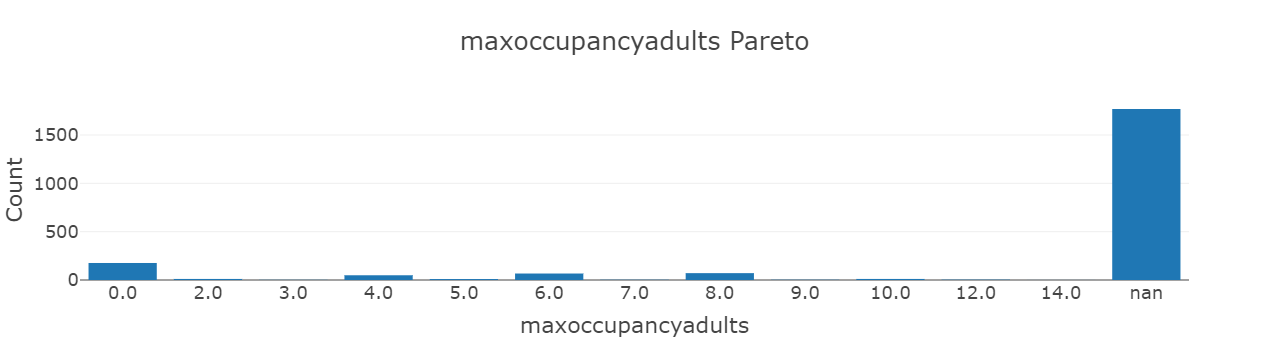

In [228]:
d1 = units.maxoccupancyadults.value_counts(dropna=False).sort_index()
fig = go.Figure(go.Bar(x=d1.index.astype(str), y=d1))
fig.update_layout(title='maxoccupancyadults Pareto', 
                  xaxis={'type':'category', 'title':'maxoccupancyadults'},
                 yaxis={'title':'Count'})

fig.show()

Above is a pareto chart of the maxoccupancyadults values. 81% of values are missing. The most common non-null value is 0 with 176 samples. 

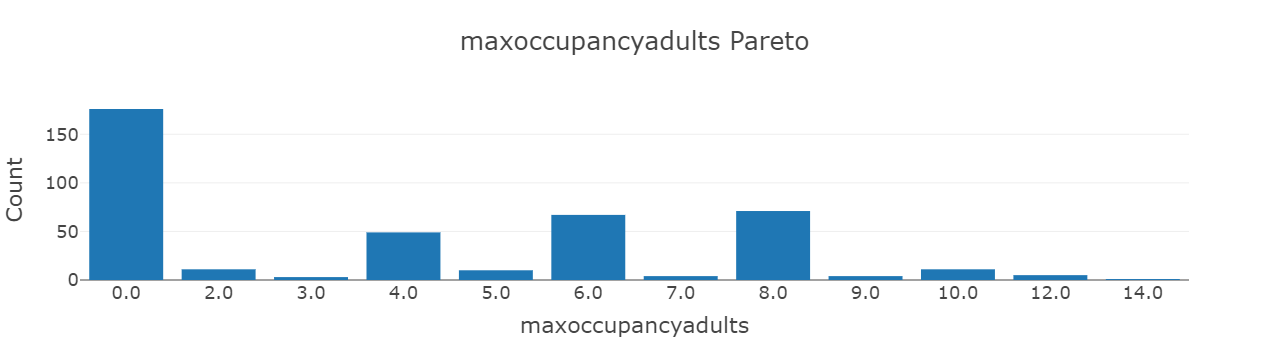

In [229]:
d2 = units.maxoccupancyadults.value_counts().sort_index()
fig = go.Figure(go.Bar(x=d2.index.astype(str), y=d2))
fig.update_layout(title='maxoccupancyadults Pareto', 
                  xaxis={'type':'category', 'title':'maxoccupancyadults'},
                 yaxis={'title':'Count'})

fig.show()

I checked a dozen or so listings on the vacasa site that have a 0 maxoccupancyadults in the dataset. They all had a max occupancy of either 6 or 8, the two most common values in the dataset. While it's not clear what 0 was used to encode, it makes sense that it doesn't actually represent 0 occupancy rentals. It could be that 0 was originally used for units that either had no max occupancy or where the max occupancy was still pending/unknown.

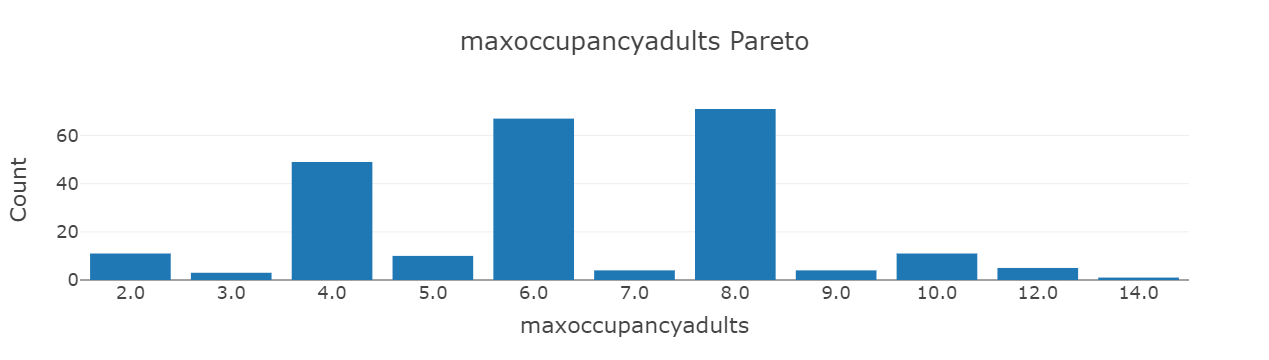

In [230]:
d2 = units.maxoccupancyadults.value_counts().sort_index().iloc[1:]
fig = go.Figure(go.Bar(x=d2.index.astype(str), y=d2))
fig.update_layout(title='maxoccupancyadults Pareto', 
                  xaxis={'type':'category', 'title':'maxoccupancyadults'},
                 yaxis={'title':'Count'})

fig.show()

Taking a closer look at the distribution without the value 0, there is a clear bias for even values of max occupancy over odd values. This feature seems quite important for recommending similar rentals, since someone who is searching for units that can accomodate at least 7 adults, will likely have no interest in being shown units that have a max occupancy of 5 or lower. To handle the missing values in this feature column, I can either drop the column altogether or impute the missing values. With 81% of the feature values missing, imputation can introduce significant bias. Dropping the feature altogether would prevent this bias, however we run into a worse problem than that described above. Without this feature column, max occupancy will not be considered and we will be recommending units that could have any max occupancy. I believe most customers would not appreciate being recommended similar units which cannot accomodate their party size. For this reason I think it would be best to impute the missing values. 

The most straightforward methods of imputation would be using either the mean/median of the column or most common values of either 8 or 6. However, this would introduce significant bias and could have very large errors. There is very likely some correlation between the number of bedrooms and the max occupancy of a unit. We can explore this relationship as a potential strategy for imputatoin. The benefit of this is that there are no missing values for the bedrooms feature!

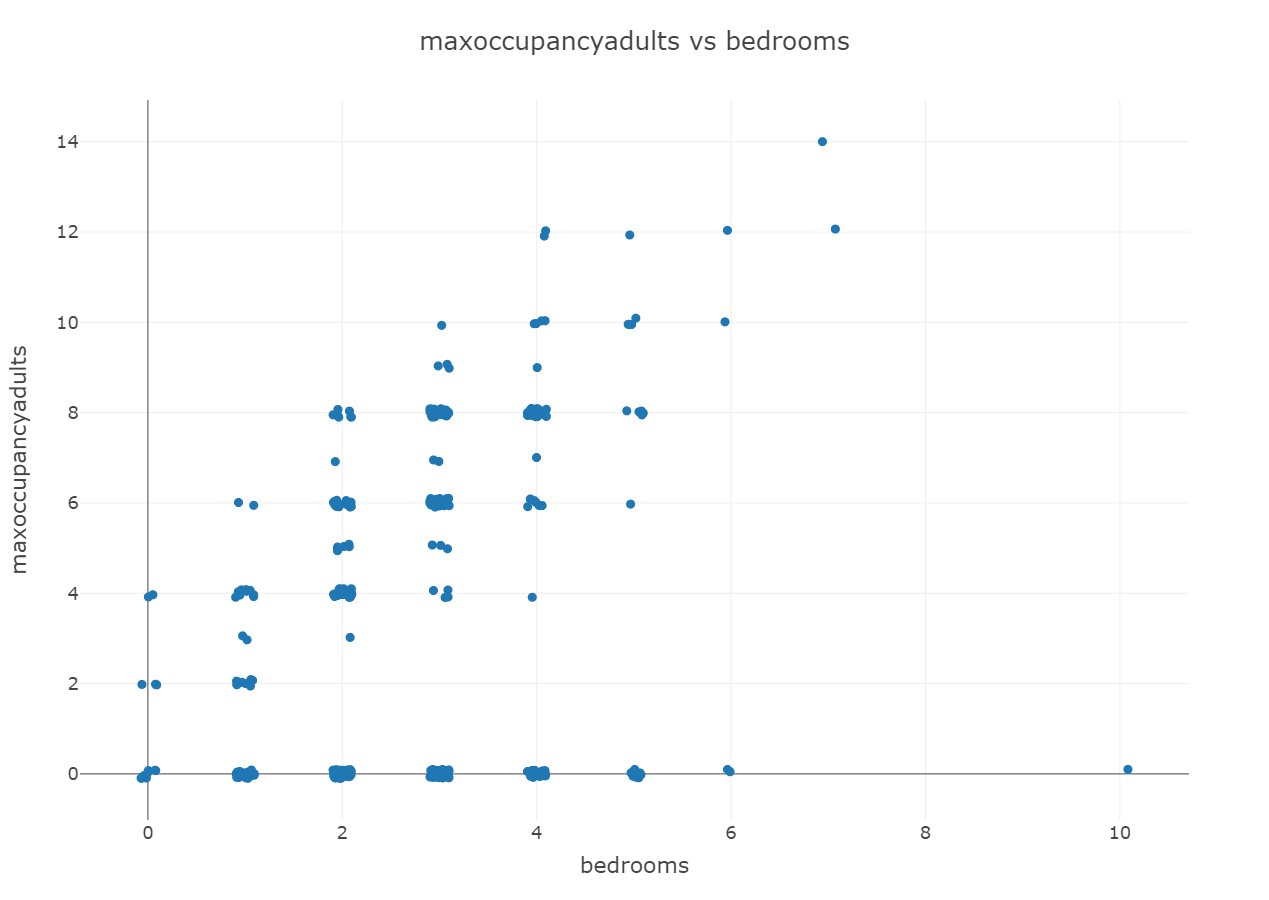

In [231]:
x = units[units.maxoccupancyadults.notnull()].loc[:,'bedrooms']
# apply jitter with a random float between -0.1 and 0.1, uniformly distributed
x = x.apply(lambda z: z + (np.random.rand() - 0.5)/5)

y = units[units.maxoccupancyadults.notnull()].loc[:,'maxoccupancyadults']
y = y.apply(lambda z: z + (np.random.rand() - 0.5)/5)

fig = go.Figure(go.Scatter(x=x, y=y, mode='markers'))
fig.update_layout(title='maxoccupancyadults vs bedrooms',
                 xaxis={'title':'bedrooms'},
                 yaxis={'title':'maxoccupancyadults'},
                 width=900,
                 height=900)

fig.show()

Above is a scatter plot showing the relationship between maxoccupancy and adults. There is a clear linear relationship between the two features. The 0s distort the data so for now I'll ignore them.

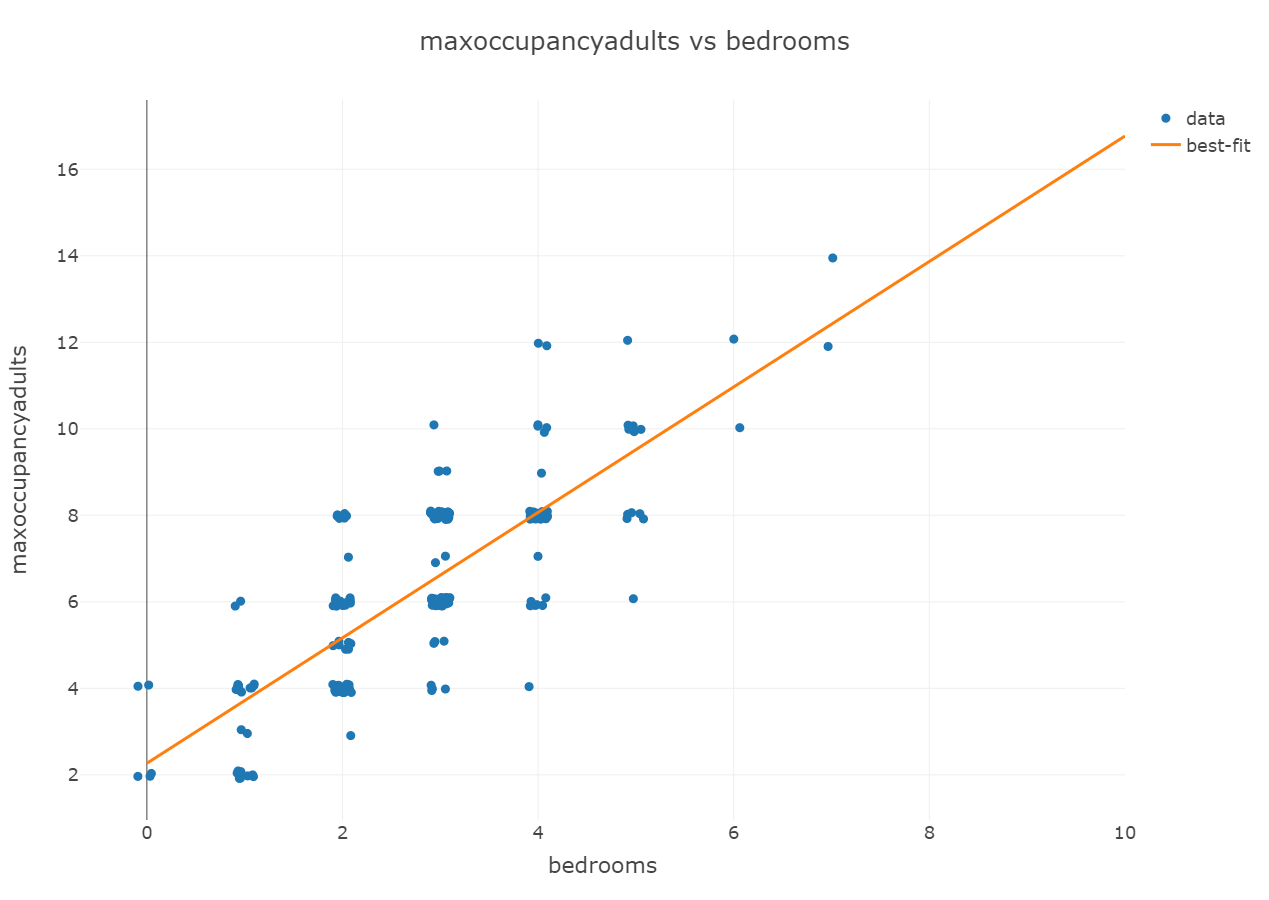

In [316]:
np.random.seed(42)

x = units[units.maxoccupancyadults.notnull() & units.maxoccupancyadults!=0].loc[:,'bedrooms']
# apply jitter with a random float between -0.1 and 0.1, uniformly distributed
x = x.apply(lambda z: z + (np.random.rand() - 0.5)/5)

y = units[units.maxoccupancyadults.notnull() & units.maxoccupancyadults!=0].loc[:,'maxoccupancyadults']
y = y.apply(lambda z: z + (np.random.rand() - 0.5)/5)

# linear regression
reg = LinearRegression().fit(np.vstack(x), y)
x1 = list(range(11))
y1 = x1*reg.coef_ + reg.intercept_

fig = go.Figure([go.Scatter(name='data', x=x, y=y, mode='markers'),
                 go.Scatter(name='best-fit', x=x1, y=y1, mode='lines')])
fig.update_layout(title='maxoccupancyadults vs bedrooms',
                 xaxis={'title':'bedrooms'},
                 yaxis={'title':'maxoccupancyadults'},
                 width=900,
                 height=900)

fig.show()

Above is the same scatter plot with 0s omitted. Now we can see a much clearer trend. Before moving forward it's important to note that we are modeling a very small sample of the total population. The plot above contains 236 out of the 2181 total samples, representing about 11% of the data. I'm assuming that this trend between the bedrooms and maxoccupancyadults distributions is roughly the same in the total population.

In order to use the number of bedrooms as a proxy for maxoccupancyadults, I have to decide what part of the distribution to use for converting bedrooms to maxoccupancy. Consider the case where we simply use the equation from the best fit line to impute maxoccupancyadults from bedrooms. For a unit with 4 bedrooms, the imputed value of maxoccupancyadults would be 8. However, since 8 is roughly the midpoint of maxoccupancyadults values for units with 8 bedrooms, half of the imputed units would actually have a max occupancy lower than 8. This would lead us to recommending units with a lower max occupancy than what a customer was looking for up to half the time. This is exactly the case we wanted to avoid. 

*In reality, this would happen much less than half the time since maxoccupancyadults can only take on integer values and the distribution is not exactly symmetric.*

A safer strategy would be to fit a line to a lower quantile of the distribution and use it to impute maxoccupancy values. More on this strategy below. I start by computing the residuals and finding the lower 10% of points with the largest residuals below the best-fit line.

In [327]:
# compute residuals between all points & the regression line
residuals = y - reg.predict(np.vstack(x))

# get only the residuals below the regression line
lower_residuals = residuals[residuals < 0].sort_values(ascending=True)

# get the top 10% largest residuals
lower_10_residuals = lower_residuals.head(round(len(y)*0.1))

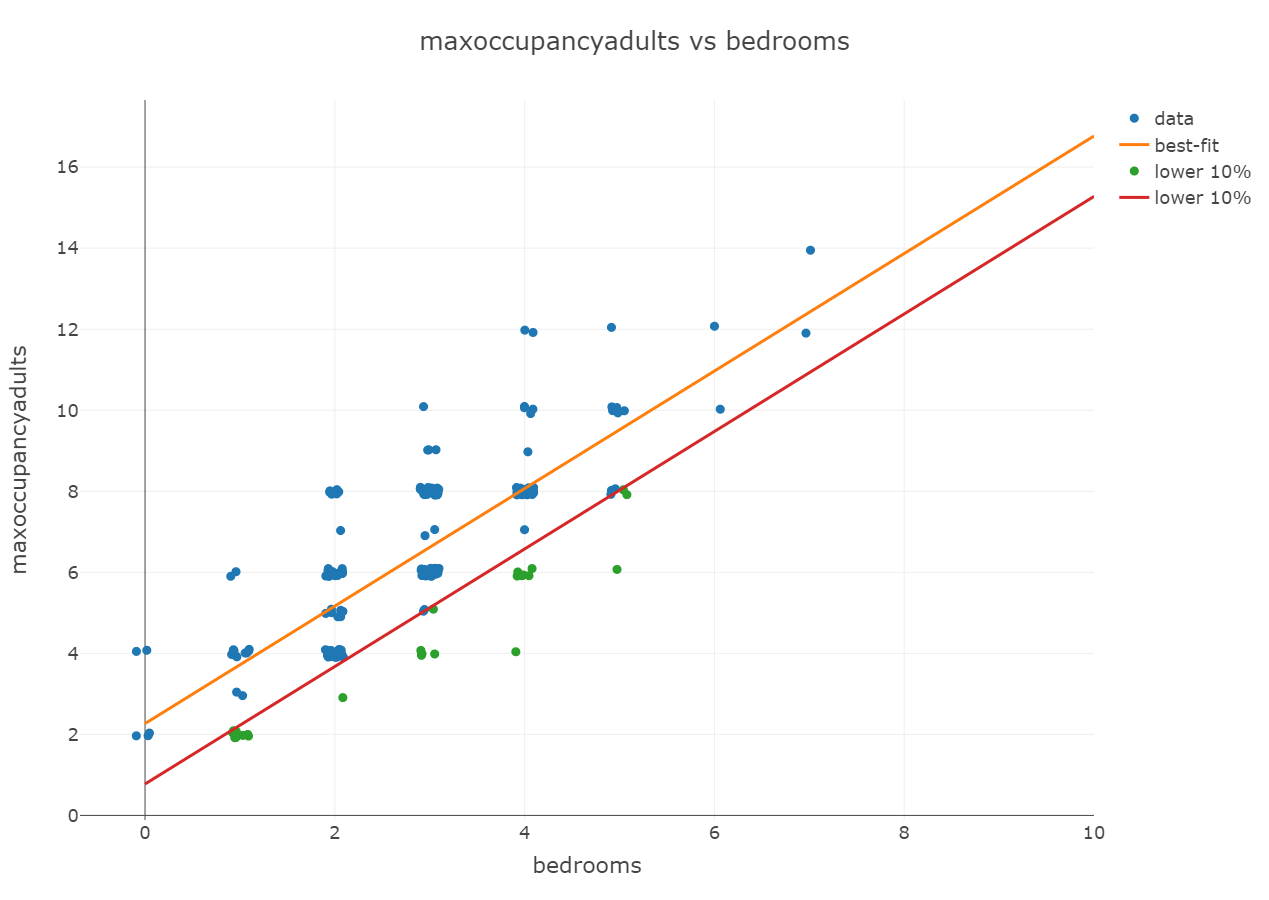

In [328]:
# upper 90% markers
x1 = x.loc[x.index.difference(lower_10_residuals.index)]
y1 = y.loc[y.index.difference(lower_10_residuals.index)]

# best-fit
x2 = list(range(11))
y2 = x2*reg.coef_ + reg.intercept_

# lower 10% markers
x3 = x.loc[lower_10_residuals.index]
y3 = y.loc[lower_10_residuals.index]

# lower 10% line
y4 = x2*reg.coef_ + reg.intercept_ * 0.342

fig = go.Figure([go.Scatter(name='data', x=x1, y=y1, mode='markers'),
                 go.Scatter(name='best-fit', x=x2, y=y2, mode='lines'),
                go.Scatter(name='lower 10%', x=x3, y=y3, mode='markers'),
                 go.Scatter(name='lower 10%', x=x2, y=y4, mode='lines')])
fig.update_layout(title='maxoccupancyadults vs bedrooms',
                 xaxis={'title':'bedrooms'},
                 yaxis={'title':'maxoccupancyadults'},
                 width=900,
                 height=900)

fig.show()

The scatter plot above now shows the bottom 10% of points with the largest residuals. Let's look at an example of using this red line to impute maxoccupancyadults from bedrooms. Consider a 3 bedroom unit, using the lower 10% line we would impute a maxoccupancyadults of 5. There is less than a 10% chance in this case that the true max occupancy is lower than 5. In the case of the actual data shown above, only 4 out of 85 samples would have actually had a lower max occupancy of 4 bedrooms.

This leads me to the final and safest strategy which would be to impute maxoccupancyadults with the minimum values for each number of bedrooms. For example, if the number of bedrooms is 1, the maxoccupancy would be 2. If bedrooms is 4, then the maxoccupancy would be 4. There is no guarantee of course that there will be samples in the full dataset that still fall below this safest method.

Now I want to discuss the potential drawbacks of these various methods of imputation. Because we're imputing around 81% of the data, our imputation will strongly determine the resulting distribution. If for example we impute using the best-fit regression line, we won't change the best-fit of the total population by much, it'll look very similar to the best-fit line on the sample data above. This isn't the case for the safer options. If we use the red line for example, we will shift the regression line on the total population below what we see in the sample data above. The safer our imputation, the farther below the population average we go and the more likely it is we're inaccurately imputing maxoccupancyadults. Some of the lower 10% values (green dots) for example already appear to be outliers. What is the consequence of inaccurately imputing maxoccupancy adults?

1. We're going to alter the relationship between maxoccupancyadults and bedrooms. The slope will be similar which is most important, but the line will be shifted down.
2. All else being equal, a unit which was not imputed could have a larger dissimilarity to two units that were imputed simply because they were both imputed with the same strategy.

For now, it seems worth it to impute this feature using a safer approach such as the lower 10% line or the minimum value for each value of bedroom. We will try this in the data munging section.

#### *fullbaths*

In [105]:
units.fullbaths.value_counts()

2     1167
1      497
3      381
4       82
0       21
5       20
6        7
7        3
10       2
11       1
Name: fullbaths, dtype: int64

*fullbaths* has no missing values and is the number of full baths.

#### *terminated*

In [106]:
units.terminated.value_counts(dropna=False)

0    1664
1     517
Name: terminated, dtype: int64

*terminated* also has no missing values. It's not clear what the *terminated* feature is. My initial thought is that it's a flag for whether a listing is active or not, however I have found listings that are active on the vacasa website that have a *terminated* value of 1. Again, the discrepancy may be due to the difference in time that we're looking at the data. One way to check for this is to join the *units* dataset to the *official_reservations* dataset, the top 5 rows of this join are shown below.

In [107]:
official_reservations.join(units, on='unitid').head()

,cancelled,unitid,creationdate,firstnight,lastnight,reservation_source_id,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
0,0,4703,2018-01-01 08:42:41,2018-02-08 00:00:00,2018-02-11 00:00:00,8,41.0,439.0,NaN,NaN,4.0,1.0,5.0,NaN,1.0
1,1,9980,2018-01-01 19:08:32,2018-04-07 00:00:00,2018-04-13 00:00:00,1,370.0,162.0,1.0,2.0,1.0,1.0,1.0,NaN,-1.0
2,0,10938,2018-01-02 01:14:25,2018-01-09 00:00:00,2018-01-10 00:00:00,8,46.0,119.0,NaN,NaN,1.0,0.0,0.0,NaN,2.0
3,0,6057,2018-01-02 10:26:26,2018-07-23 00:00:00,2018-07-25 00:00:00,12,545.0,163.0,NaN,NaN,2.0,0.0,2.0,"There are three beaches: The Marina, Lake Lodg...",-1.0
4,1,13154,2018-01-02 09:51:18,2018-01-12 00:00:00,2018-01-14 00:00:00,1,32.0,158.0,NaN,NaN,2.0,1.0,3.0,NaN,-1.0


We can see that there are 3 reservations that were actively booked even though they had a *terminated* value of 1. This goes against our initial guess of what the *terminated* feature is. But we can confirm that units with *terminated* values of both 0 and 1 were actively booked during 2018.

#### *bedrooms*

In [108]:
units.bedrooms.value_counts(dropna=False)

3.0     822
2.0     594
4.0     340
1.0     228
5.0      86
0.0      67
6.0      24
7.0       7
NaN       5
8.0       5
9.0       1
16.0      1
10.0      1
Name: bedrooms, dtype: int64

*bedrooms* is self explanatory and contains only 5 missing values. The most common bedroom values are 3, 2, and 4 in order of most common to least.

#### *beachaccess*

In [109]:
units.beachaccess.notnull().sum()

465

In [110]:
units[units.beachaccess.notnull()].head()

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,NaN,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,NaN,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,NaN,NaN,3,1,4.0,0,1.0
2232,225,138,1.0,0.0,2,1,3.0,Lake Elsinore is 10 minutes from home. \r\nFor...,-1.0
3277,368,106,NaN,0.0,1,1,1.0,One block walk to the ocean and public beach. ...,2.0


There are only 465 out of 2181 units with non-missing *beachacess* values. Looking at a subset of these (above), the values of *beachaccess* mostly describe directions to get to the beach for those units that do have beachacess.

In [410]:
for i in units[units.beachaccess.notnull()].beachaccess.head(10):
    print(i)

Drive 5 miles south on 89 to Tahoe City.  After the light, look for a right to Commons Beach. About a 13 minute drive.
Walk down Ellis to the Lake.
0
Lake Elsinore is 10 minutes from home. 
For more information & lake activities please visit: 
http://www.lake-elsinore.org
One block walk to the ocean and public beach. Pet friendly dogs on-leash.
Yes- 3 blocks West down Long Branch there is beach access.
Beach access is 1/2 block or less than a five-minute walk to the spectacular Speedboat Beach.
Donner lake is about 3 miles away
There are three beaches: The Marina, Lake Lodge and Dunn Court. You can swim inside the designated areas only. On private lakefront property, swimming is confined to within thirty feet (30) of the shoreline or private dock.
Parking in the Marina beach parking lot is not permitted on Friday, Saturday or Sunday, and is reserved for homeowners. The beach can be accessed via water taxi, and please call Pine Mountain Lake with any questions:(209) 962-8615.

This home

Above I've printed the *beachaccess* for the first 10 samples that don't have missing data. There is one value of 0. The rest of the values are some sort of directions for how to access the beach. Since customers typically are interested in whether or not units have beachaccess or not and not actually the required steps to get to the beach, we can simply one-hot encode this feature to indicate whether a sample has beach access or not. This will simplify the analysis.

#### *hottub*

In [111]:
units.hottub.value_counts(dropna=False)

-1.0    1209
 2.0     471
 1.0     440
 NaN      61
Name: hottub, dtype: int64

*hottub* has 3 unique values and 61 out of 2181 missing values. Our sample listing 24292 had a hot tub in the listing and it's data shows a value of 1. Let's find a listing on the vacasa that has a value of 2 in the dataset.

https://www.vacasa.com/unit/25243

The first listing I found is 25243. It has a value of 2 for the hottub feature and on the vacasa listing it shows that the hot tub is **shared** (below), let's find another example.

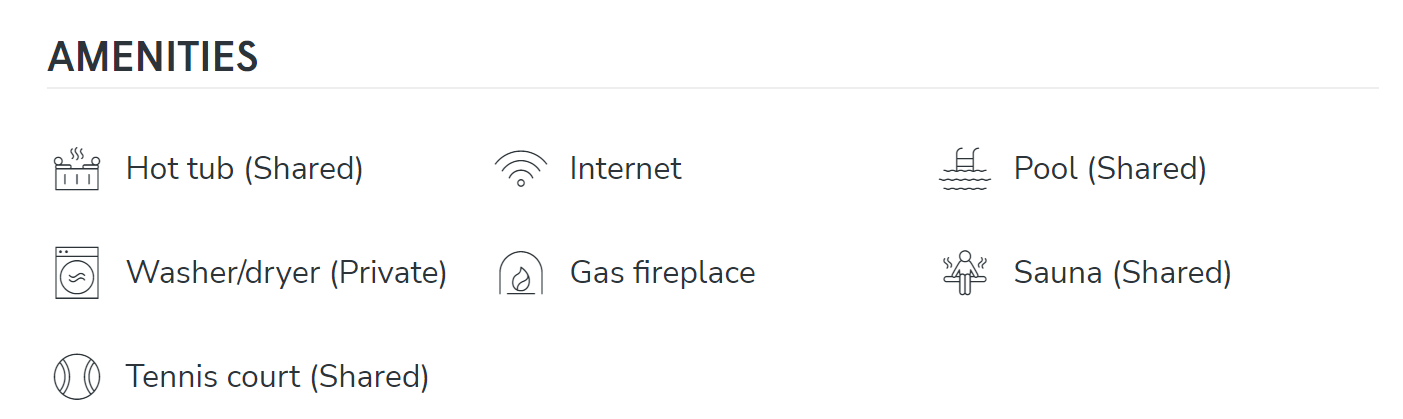

https://www.vacasa.com/unit/21686

The next listing I found on the vacasa website is unit 21686 which also shows it has a **shared** hot tub on the listing.

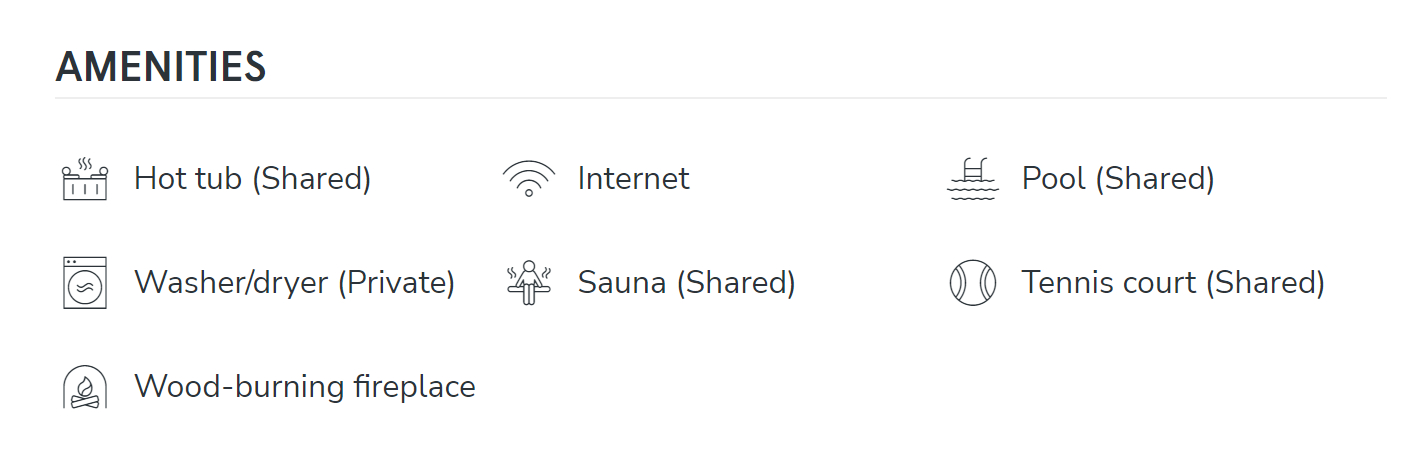

It's likely then that a value of -1 corresponds to no hottub. Let's verify by looking at a listing with the value -1.

https://www.vacasa.com/unit/25266

This listing indeed shows that it has no hottub.

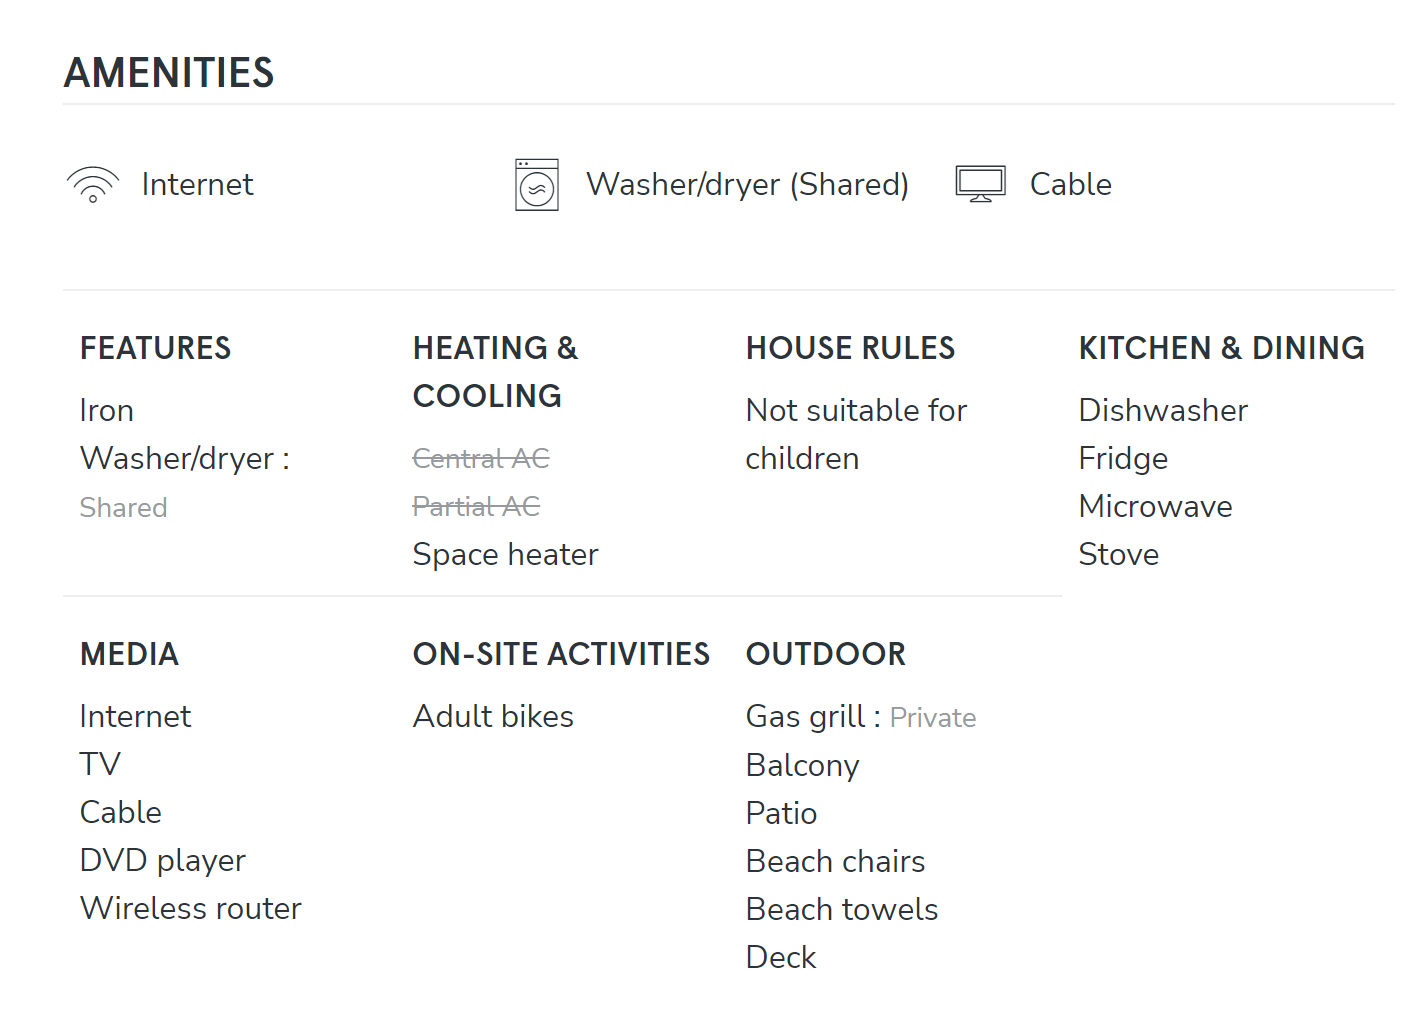

### *segment_page_views* Dataset

In [112]:
segment_page_views = pd.read_csv('data/segment page views.csv')
segment_page_views.head()

,anonymous_id,unit_id
0,68ebf758-2bb1-4719-a463-6e15540f0a08,11774
1,68ebf758-2bb1-4719-a463-6e15540f0a08,959
2,04041e02-7a3e-4d62-b862-610234b47943,11818
3,04041e02-7a3e-4d62-b862-610234b47943,11818
4,70dce651-7631-44e0-b677-c286dd57fb1c,12347


In [113]:
segment_page_views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96845 entries, 0 to 96844
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anonymous_id  96845 non-null  object
 1   unit_id       96845 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


*segment_page_views* records the anonymous_id for a user of the website when the user clicks through to the listing of a particular unit_id. This should in theory give us the number of unique viewers of each unit's page. There are 96,845 records with no missing values.

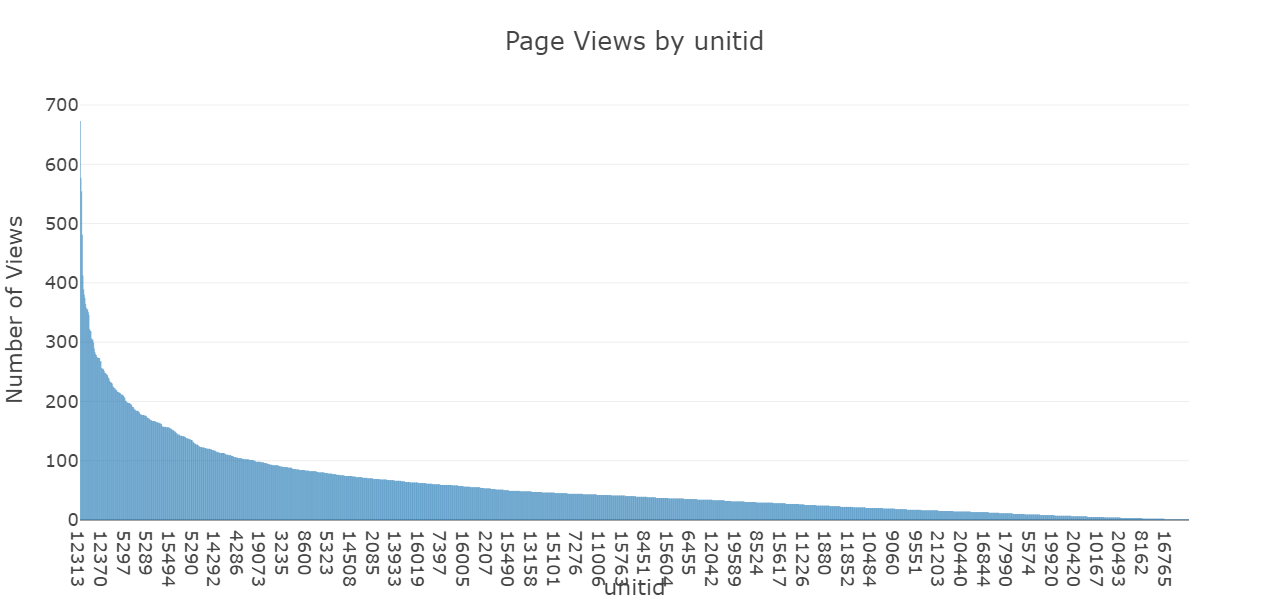

In [114]:
page_view_counts = segment_page_views.groupby('unit_id').count().sort_values('anonymous_id', ascending=False)
fig = go.Figure(go.Bar(x=page_view_counts.index, y=page_view_counts.anonymous_id))
fig.update_layout(title='Page Views by unitid',
                  yaxis={'title':'Number of Views'},
                  xaxis={'title':'unitid', 'type':'category'},
                  width=1200,
                  height=600)

fig.show()

Above is the pareto of page views by *unitid*. Unit 12313 has the highest number of page views at 673. This data may be useful as a supplementary method of choosing similar units to recommend. For example, if there are 5 units that are very equally similar to the unit abandoned in a cart, you could choose the 3 units that have higher page views since this could mean they're more popular and desired amongst customers, and therefore possibly most likely to lead to a conversion.

### *segment_reservations* Dataset

In [115]:
segment_reservations = pd.read_csv('data/segment_reservations.csv')
segment_reservations.head()

,anonymous_id,reservation_id
0,cb4d14ab-ee3d-431d-aebd-2b46651dd280,1167636
1,726448eb-9ffc-4c7b-af00-5b0ac02c3ae6,1172722
2,4f753e6d-a71c-4196-a600-a2e01b826b94,1174695
3,16a8ebe3-fbec-4f75-a452-4e83ef64c735,1178629
4,ab0c1b24-e828-4a66-92d4-8bcc69c5ddca,1183434


In [116]:
segment_reservations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   anonymous_id    4830 non-null   object
 1   reservation_id  4830 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.6+ KB


*segment_reservations* contains 4830 records with 0 missing values. The table can be joined with *segment_page_views* with the *anonymous_id* column. It's also joinable to the *official_reservations* table through the *reservation_id*.

## Data Munging

To find the most similar units, we're going to use a KNN model. Before we can feed the data into such a model, we have to deal with the missing values.

In [117]:
units.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 251 to 25557
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cityid              2181 non-null   int64  
 1   avgbaserate         2181 non-null   int64  
 2   dogs                548 non-null    float64
 3   maxoccupancyadults  412 non-null    float64
 4   fullbaths           2181 non-null   int64  
 5   terminated          2181 non-null   int64  
 6   bedrooms            2176 non-null   float64
 7   beachaccess         465 non-null    object 
 8   hottub              2120 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 234.9+ KB


### *dogs*

In [118]:
units.dogs.isnull().sum()/len(units)

0.7487391104997707

The *dogs* feature column has 75% missing values. 

In [119]:
units.dogs.unique()

array([nan,  1.,  0.])

The *dogs* feature contains mostly missing values. Non missing values are either 0, presumably for no pets and 1 if pets are allowed. My initial thought was to impute missing values to -1, however this could have unintended consequences. For example, all else being equal, consider 3 units all with a different value of dogs, -1, 0, or 1. In this case, a value of 0 would be closer to -1 than 1. So -1 and 0 are more similar than -1 and 1, but this shouldn't be the case as we don't know what the missing value should be and there's no reason it should lean towards 0.

I could impute missing values to 0.5, this value would put missing values equidistant between 0 and 1. Or another strategy would be to create the dummy variables dogs_no, dogs_yes, dogs_missing with binary values. However, in general it's best to maintain a smaller number of dimensions for KNN models and we may add more features later, so I'll opt for imputing missing values with the value 0.5.

In [390]:
units.dogs = units.dogs.fillna('0.5')

In [391]:
units.head()

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,0.5,7.0,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,0.5,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,0.5,7.0,3,1,4.0,0,1.0
1332,130,0,1.0,7.0,4,1,4.0,NaN,1.0
1374,43,0,0.5,5.0,2,1,3.0,NaN,NaN


### *maxoccupancyadults*

In [375]:
bedrooms = sorted(units.bedrooms.dropna().unique())
occupancy = bedrooms * reg.coef_ + reg.intercept_ * 0.342

mapping = {}
for i, j in zip(bedrooms, occupancy):
    mapping[i] = round(j)

In [376]:
mapping

{0.0: 1,
 1.0: 2,
 2.0: 4,
 3.0: 5,
 4.0: 7,
 5.0: 8,
 6.0: 9,
 7.0: 11,
 8.0: 12,
 9.0: 14,
 10.0: 15,
 16.0: 24}

In [381]:
units[units.maxoccupancyadults.isnull()]

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,NaN,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
876,84,0,NaN,NaN,3,1,4.0,0,1.0
1332,130,0,1.0,NaN,4,1,4.0,NaN,1.0
1374,43,0,NaN,NaN,2,1,3.0,NaN,NaN
1439,130,0,1.0,NaN,6,0,8.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...
25061,41,193,NaN,NaN,2,0,2.0,NaN,2.0
25064,206,173,1.0,NaN,3,0,2.0,NaN,2.0
25243,32,282,NaN,NaN,3,0,4.0,NaN,2.0


In [382]:
units[units.maxoccupancyadults.isnull()].bedrooms.map(mapping)

unitid
251       7.0
876       7.0
1332      7.0
1374      5.0
1439     12.0
         ... 
25061     4.0
25064     4.0
25243     7.0
25390     5.0
25557     7.0
Name: bedrooms, Length: 1769, dtype: float64

In [387]:
units.maxoccupancyadults.fillna(units[units.maxoccupancyadults.isnull()].bedrooms.map(mapping), inplace=True)

In [388]:
units

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,7.0,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,NaN,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,NaN,7.0,3,1,4.0,0,1.0
1332,130,0,1.0,7.0,4,1,4.0,NaN,1.0
1374,43,0,NaN,5.0,2,1,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
25264,189,428,NaN,10.0,2,0,4.0,NaN,-1.0
25265,189,225,NaN,6.0,1,0,2.0,NaN,-1.0
25266,189,225,NaN,4.0,1,0,2.0,NaN,-1.0


In [392]:
units.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 251 to 25557
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cityid              2181 non-null   int64  
 1   avgbaserate         2181 non-null   int64  
 2   dogs                2181 non-null   object 
 3   maxoccupancyadults  2176 non-null   float64
 4   fullbaths           2181 non-null   int64  
 5   terminated          2181 non-null   int64  
 6   bedrooms            2176 non-null   float64
 7   beachaccess         465 non-null    object 
 8   hottub              2120 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 234.9+ KB


### *beachaccess*

In [424]:
units[units.beachaccess.notnull()]

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,0.5,7.0,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,0.5,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,0.5,7.0,3,1,4.0,0,1.0
2232,225,138,1.0,0.0,2,1,3.0,Lake Elsinore is 10 minutes from home. \r\nFor...,-1.0
3277,368,106,0.5,0.0,1,1,1.0,One block walk to the ocean and public beach. ...,2.0
...,...,...,...,...,...,...,...,...,...
23161,486,360,0.5,5.0,2,0,3.0,There is no beach access.,1.0
23496,165,923,0.5,12.0,4,0,6.0,45 steps to the beach,-1.0
23559,458,549,0.5,7.0,3,0,4.0,Beach Front - Walk on from the Deck,1.0


In [425]:
for i in units[units.beachaccess.notnull()].beachaccess:
    if 'no beach' in i.lower():
        print(i)

There is no beach/water access from this unit
There is no beach access immediate to the house although there is beach access less then two minutes driving distance to the South of home.
Just feet away from the cliffs, no beach access
There is no beach or water access.
There is no beach access.
